# Lecture 18

This lecture solves more Material Balance Example Problems

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Example Problem 01

The reversible, gas-phase, homogeneous reaction shown below is carried out in a well-mixed batch reactor operating at a constant temperature ($T = 298$K) and a constant pressure ($P = 1.0$ atm). 

$$A \rightleftharpoons 4B$$

The reaction is first order in A and fourth order in B; additional data are given below: 

\begin{align}
    k_f &= 0.5 \ \textrm{min}^{-1}\\
    k_r &= 20 \ \textrm{L}^{3} \ \textrm{mol}^{-3} \textrm{min}^{-1}\\
    T   &= 298 \ \textrm{K}\\
    P   &= 1.0 \ \textrm{atm}\\
    V_0 &= 1.0 \ \textrm{L}\\
    K_C &= 0.025 \ \textrm{mol}^3 \ \textrm{L}^{-3}
\end{align}

The reactor is initially charged with pure compound A.  How long will it take to achieve 80\% conversion of species A?

**Answer**: t = 3.26 min

### Solution to Example Problem 01

Since this problem asks how long it will take to achieve a specific fractional conversion of A, my instinct is to write a material balance on A for this well-mixed batch reactor:

$$\frac{dN_A}{dt} = R_AV$$

We define $R_A$ as usual to find:

$$R_A = -r$$

And then we are given reaction orders, so we can write a rate expression.

$$r = k_fC_A - k_rC_B^4$$

Here we see our first complication: the rate of reaction depends on the concentration of species B.  Our next complication arises when we define concentration.  Since we are in a batch reactor, we define concentrations for A and B as:

\begin{align}
    C_A &= N_A/V \\
    C_B &= N_B/V
\end{align}

We see that the volume appears here. These concentrations represent the concentration in the reactor at any point in time, t.  So, relative to the starting point, $N_A$ and $N_B$ are both changing.  The less obvious thing is that the volume of the reactor is also changing.  Here's why:

The reactor temperature and pressure are fixed at 298K and 1 atm, respectively.  Because the pressure is low, we can use the ideal gas law to define the volume of the system:

$$V = \frac{N_TRT}{P}$$

In other words, for a fixed temperature and pressure, the volume of the reactor scales directly with the total number of moles in the reactor. For this reaction, we can see clearly that every time the reaction occurs, it consumes 1 mole of A and produces 4 moles of B.  This means the reaction causes an increase in the number of moles in the system, so as it progresses, the volume of the reactor must increase to maintain a constant temperature and pressure.

This means that we also have to keep track of the total number of moles in our system:

$$N_T = N_A + N_B$$

For me, the easiest way to handle this is to just write a balance on each species and solve the set of coupled differential equations numerically:

\begin{align}
    \frac{dN_A}{dt} = R_AV \\
    \frac{dN_B}{dt} = R_BV
\end{align}

Now we just make sure that everything on the right hand side of those two balances is defined in terms of contants or the three variables tracked by our ODE solver (t, NA, NB).

\begin{align}
    R_A = -r \\
    R_B = 4r
\end{align}

Where rate is given as:

$$r = k_fC_A - k_rC_B^4$$

This means we need to define concentrations in terms of NA and NB:

\begin{align}
    C_A = N_A/V \\
    C_B = N_B/V
\end{align}

And we know that Volume can be defined in terms of the total moles in the system; hence we define:

$$N_T = N_A + N_B$$

And use this result with the ideal gas law to calculate system volume.

$$V = \frac{N_TRT}{P}$$

Now $R_AV$ and $R_BV$ are fully defined in terms of t, NA, and NB, and we can solve this with solve_ivp.

First, we create the function that specifies the ODE system.

In [2]:
def P01(t,var):
    NA = var[0]
    NB = var[1]

    T = 298   #K
    P = 1.0   #atm
    R = 0.0821  #mol/L/K/atm
    kf = 0.5 #1/min
    kr = 20   #L^3/mol^3/min

    NT = NA + NB

    V  = NT*R*T/P

    CA = NA/V
    CB = NB/V

    r  = kf*CA - kr*CB**4
    RA = -r
    RB = 4*r
    D1 = RA*V
    D2 = RB*V
    return [D1, D2]

Next, we set up the initial value problem solver.  We're working with NA and NB as our dependent variables, so we need their initial values.  These are easy to calculate using the ideal gas law with the initial T, P, V and composition of the system, all of which are given in the problem statement.  Once that is done, we use solve_ivp as ususal and then interpolate to find the time where $X_A = 0.8$.

Doing so, we find $t = 3.26$ min.

The time required to achieve 80% conversion is 3.26 minutes


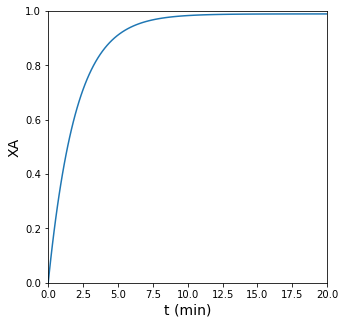

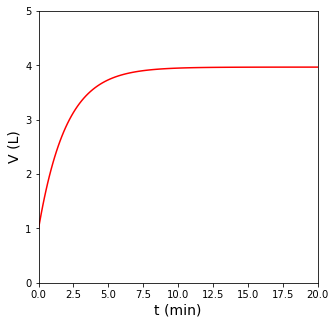

In [3]:
T     = 298   #K
P     = 1.0   #atm
R     = 0.0821  #mol/L/K/atm
V0    = 1.0   #L
NA0   = P*V0/R/T
NB0   = 0
var0  = [NA0, NB0]
tspan = (0, 20)
ans   = solve_ivp(P01, tspan, var0, atol = 1e-10, rtol = 1e-10)
t     = ans.t
NA    = ans.y[0,:]
NB    = ans.y[1,:]
XA    = (NA0 - NA)/NA0
NT    = NA + NB
V     = NT*R*T/P

itp1 = interp1d(XA, t)
print(f'The time required to achieve 80% conversion is {itp1(0.8):0.2f} minutes')

plt.figure(1, figsize = (5, 5))
plt.plot(t, XA)
plt.xlim(0, 20)
plt.xlabel('t (min)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('XA', fontsize = 14)
plt.show(1)

plt.figure(2, figsize = (5,5))
plt.plot(t, V, color = 'red')
plt.xlim(0, 20)
plt.xlabel('t (min)', fontsize = 14)
plt.ylim(0, 5)
plt.ylabel('V (L)', fontsize = 14)
plt.show(2)

## Example Problem 02

The reversible, gas-phase, homogeneous reaction shown below is carried out in a well-mixed batch reactor operating at a constant temperature ($T = 298$K) and a constant Volume ($V = 1.0$ L). 

$$A \rightleftharpoons 4B$$

The reaction is first order in A and fourth order in B; additional data are given below: 

\begin{align}
    k_f &= 0.5 \ \textrm{min}^{-1}\\
    k_r &= 20 \ \textrm{L}^{3} \ \textrm{mol}^{-3} \textrm{min}^{-1}\\
    T   &= 298 \ \textrm{K}\\
    P_0 &= 1.0 \ \textrm{atm}\\
    V   &= 1.0 \ \textrm{L}\\
    K_C &= 0.025 \ \textrm{mol}^3 \ \textrm{L}^{-3}
\end{align}

The reactor is initially charged with pure compound A.  How long will it take to achieve 80\% conversion of species A? 

### Solution to Example Problem 02

This problem is almost identical to the one above except for the fact that we fix the volume constant and no longer have to solve for it with the ideal gas law.  Otherwise, we approach it pretty much the same way.  Since my rate law depends on both $C_A$ and $C_B$, I'll write a balance on both species.

\begin{align}
    \frac{dN_A}{dt} = R_AV \\
    \frac{dN_B}{dt} = R_BV
\end{align}

Now we just make sure that everything on the right hand side of those two balances is defined in terms of contants or the three variables tracked by our ODE solver (t, NA, NB).

\begin{align}
    R_A = -r \\
    R_B = 4r
\end{align}

Where rate is given as:

$$r = k_fC_A - k_rC_B^4$$

This means we need to define concentrations in terms of NA and NB:

\begin{align}
    C_A = N_A/V \\
    C_B = N_B/V
\end{align}

And in this case, the volume is fixed at 1.0L.  At this point, we have written all the equations that we need, and we can solve this with an ODE solver just as we did above.

In this case, we find that this reversible reaction reaches chemical equilibrium at about 76% conversion.  This is the maximum conversion that can be attained if we fix the reactor volume.  The reason for this is actually that, by fixing the volume, we are forcing the pressure in the reactor to increase.  As you can see in the stoichiometry for this reaction, there are more moles on the right hand side than the left hand side, so increasing pressure favors the left hand side and will decrease the equilibrium conversion we can attain.

In [4]:
def P02(t,var):
    NA = var[0]
    NB = var[1]

    kf = 0.5 #1/min
    kr = 20   #L^3/mol^3/min

    V = 1.0   #L

    CA = NA/V
    CB = NB/V

    r = kf*CA - kr*CB**4
    RA = -r
    RB = 4*r
    D1 = RA*V
    D2 = RB*V
    return [D1, D2]

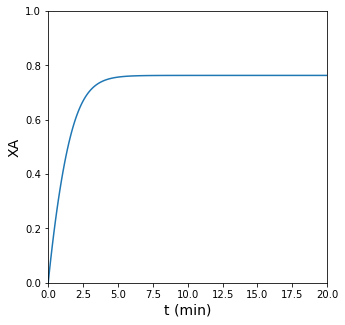

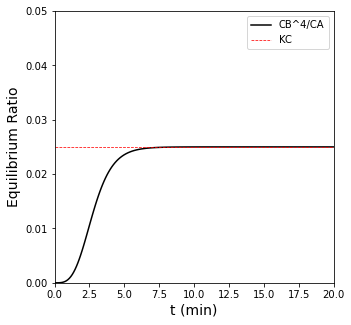

0.7630069354428065

In [5]:
T     = 298   #K
P0    = 1.0   #atm
R     = 0.0821  #mol/L/K/atm
V     = 1.0   #L
KC    = 0.025
NA0   = P0*V/R/T
NB0   = 0
var0  = [NA0, NB0]
tspan = (0, 20)
sol   = solve_ivp(P02, tspan, var0, atol = 1e-10, rtol = 1e-10)
NA    = sol.y[0,:]
NB    = sol.y[1,:]
CA    = NA/V
CB    = NB/V
XA    = (NA0 - NA)/NA0

plt.figure(1, figsize = (5, 5))
plt.plot(sol.t, XA)
plt.xlim(0, 20)
plt.xlabel('t (min)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('XA', fontsize = 14)
plt.show(1)

plt.figure(2, figsize = (5, 5))
plt.plot(sol.t, CB**4/CA, color = 'black', label = 'CB^4/CA')
plt.hlines(KC, 0, 20, color = 'red', linestyle = 'dashed', linewidth = 0.75, label = 'KC')
plt.xlim(0, 20)
plt.xlabel('t (min)', fontsize = 14)
plt.ylim(0, 0.05)
plt.ylabel('Equilibrium Ratio', fontsize = 14)
plt.legend()
plt.show(1)


XA[-1]
#interp = interp1d(XA,sol.t)
#interp(0.8)

## Example Problem 03

The reaction below is carried out in the liquid phase in a well-mixed batch reactor. 

$$A \rightarrow B$$

The reaction is second order in A.  Additional data are given below. 

\begin{align}
    k &= 3.5 \times 10^{-3} \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{min}^{-1}\\
    {V_A}^\circ &= 50 \ \textrm{mL} \ \textrm{mol}^{-1}\\
    {V_B}^\circ &= 38.46 \ \textrm{mL} \ \textrm{mol}^{-1}\\
\end{align}

The reactor is initially charged with 10 moles of species A. How long will it take to achieve 75\% conversion of species A? 

**Answer**: 37.5 minutes.

### Solution to Example Problem 03

The problem asks about fractional conversion of A, so I start by writing a balance on A:

$$\frac{dN_A}{dt} = R_AV$$

I'd like to write everything on the right hand side in terms of $N_A$ and t.  We can expand the production rate:

$$R_A = -r$$

And the reaction rate

$$r = kC_A^2$$

So far so good, the reaction rate only depends on the concentration of A.  Now we define this in terms of molar quantities of A and Volume:

$$C_A = N_A/V$$

But here, we have a problem.  As the reaction happens, species A is converted into species B, and the two species occupy a different amount of space per mole.  In other words, they have different molar volumes (${V_j}^\circ$).  So we need an equation of state to relate the number of moles of species to the volume of the system.  Here, I'll assume an ideal mixture, which is basically expressed as:

$$\sum_j C_j{V_j}^\circ = 1$$

The practical implication is that the volumes of species are additive.  For a single species, I calculate the volume it occupies, $V_j$ as:

$$V_j = N_j{V_j}^\circ$$

When we have multiple species, we calculate the total volume of the system by adding the space occupied by each species:

$$V = \sum_j {V_j}$$

Or:

$$V = \sum_j N_j{V_j}^\circ$$

In this particular example, we only have to worry about species A and species B, so:

$$V = N_A{V_A}^\circ + N_B{V_B}^\circ$$

Now that $N_B$ shows up in my definition of Volume, I have two dependent variables: $N_A$ and $N_B$.  I can either write them both in terms of a single fractional conversion or I can write balances on both A and B.  I choose the latter here because I find it more straightforward.

$$\frac{dN_B}{dt} = R_BV$$

Now we can pack our ODE system into a function and solve it with solve_ivp.

In [6]:
def P03(t,var):
    NA = var[0]
    NB = var[1]

    VA = 50e-3     #L/mol
    VB = 38.46e-3  #L/mol
    k  = 3.5e-3    #L/mol/min

    V  = NA*VA + NB*VB
    CA = NA/V

    r  = k*CA**2

    RA = -r
    RB = r
    D1 = RA*V
    D2 = RB*V
    return [D1, D2]

Now that's done, we just define the starting state and the integration span, and we can solve our problem with solve_ivp.  As usual, since we're using an interative ODE solver, it won't hit the target conversion exactly, so we use an interpolation to find the time required to achieve 75% conversion of A.

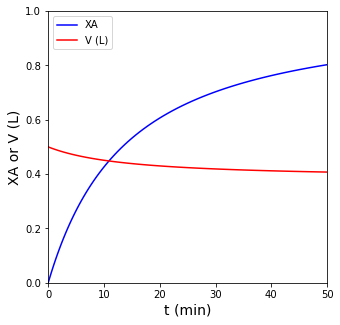

The time when conversion of A reaches 75% is 37.54 min


In [7]:
VA    = 50/1000  #L/mol
VB    = 38.46/1000 #L/mol

NA0   = 10  #mol
NB0   = 0   #mol
var0  = [NA0, NB0]
tspan = [0, 50]
ans   = solve_ivp(P03, tspan, var0, atol = 1e-10, rtol = 1e-10)
t     = ans.t
NA    = ans.y[0,:]
NB    = ans.y[1,:]
V     = NA*VA + NB*VB

XA    = (NA0 - NA)/NA0

plt.figure(1, figsize = (5,5))
plt.plot(t, XA, label = 'XA', color = 'blue')
plt.plot(t, V, label = 'V (L)', color = 'red')
plt.xlim(0, 50)
plt.xlabel('t (min)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('XA or V (L)', fontsize = 14)
plt.legend(loc = 'upper left')
plt.show(1)

int1 = interp1d(XA, t, kind = 'cubic')
t_ans = int1(0.75)

print(f'The time when conversion of A reaches 75% is {t_ans:0.2f} min')